In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


warnings.filterwarnings('ignore')
df = pd.read_csv("MakroDashboard\data\ML data\Quarterly_wide.csv")  # Make sure it has 15 columns


In [ ]:
time_series = df['time']

# Step 1: Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# Step 2: Select numeric columns
df_numeric = df.select_dtypes(include=["number"])

# Standardize numeric columns
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Add 'time' column back (unscaled, useful for plotting/temporal split)
df_final = pd.concat([df_scaled, df[['time']]], axis=1)

df_final = df.fillna(df_final.mean(numeric_only=True))


In [158]:
# Step 1: Filter columns that contain "Finland"
finland_columns = [col for col in df_final.columns if 'Finland' in col]

# Step 2: Select input and output
X = df_final.iloc[:, 2:145]               # first 145 columns as features
y = df_final[finland_columns]            # select only the Finland-related columns as targets

y_labels = y.shift(-1).dropna()


# Step 3: Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(
    X, y, time_series, test_size=0.2, random_state=42
)

In [159]:
# Model: MultiOutput wrapper around XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1
)

multi_model = MultiOutputRegressor(xgb_model)

# Fit the model
multi_model.fit(X_train, y_train)

# Predict
y_pred = multi_model.predict(X_test)

# Evaluate: Mean Squared Error per target
mse_per_target = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# Create a DataFrame to store MSE values for each target
mse_df = pd.DataFrame({
    'Target': y.columns,
    'MSE': mse_per_target
})

# 📢 Output results (print the DataFrame)
print(mse_df)

# Optionally, you can save it to a CSV file if you want:
mse_df.to_csv("MakroDashboard\\data\\ML metrics\\mse_per_target.csv", index=False)

                                              Target           MSE
0                            Current account_Finland  1.754612e-01
1                          Direct investment_Finland  6.418086e+06
2                     Employees Compensation_Finland  1.690113e+05
3                          Totlat employment_Finland  4.244077e+02
4   Final consumption expenditure households_Finland  4.705884e+05
5                              Change in GDP_Finland  1.741630e-01
6              Gross fixed capital formation_Finland  4.277254e+04
7                     Government debt to gdp_Finland  2.708495e+00
8                     Government expenditure_Finland  5.895923e+04
9                   Change in Housing prices_Finland  4.397539e-03
10                       Labour productivity_Finland  1.186048e-01
11              Net international investment_Finland  5.165148e+00
12                  Nominal unit labour cost_Finland  2.324371e-01
13                             Infaltion CPI_Finland  4.669938

In [160]:
# Evaluate: R² for each target
r2_per_target = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

#Create a DataFrame to store R² values for each target
r2_df = pd.DataFrame({
    'Target': y.columns,
    'R²': r2_per_target
})

# Output results (print the DataFrame)
print(r2_df)

# Optionally, save it to a CSV file:
r2_df.to_csv("MakroDashboard\\data\\ML metrics\\r2_per_target.csv", index=False)

                                              Target        R²
0                            Current account_Finland  0.989812
1                          Direct investment_Finland  0.997876
2                     Employees Compensation_Finland  0.995134
3                          Totlat employment_Finland  0.986869
4   Final consumption expenditure households_Finland  0.988767
5                              Change in GDP_Finland  0.894250
6              Gross fixed capital formation_Finland  0.996116
7                     Government debt to gdp_Finland  0.994969
8                     Government expenditure_Finland  0.995026
9                   Change in Housing prices_Finland  0.991864
10                       Labour productivity_Finland  0.979371
11              Net international investment_Finland  0.993400
12                  Nominal unit labour cost_Finland  0.970645
13                             Infaltion CPI_Finland  0.868576
14                    Change in energy price_Finland  0

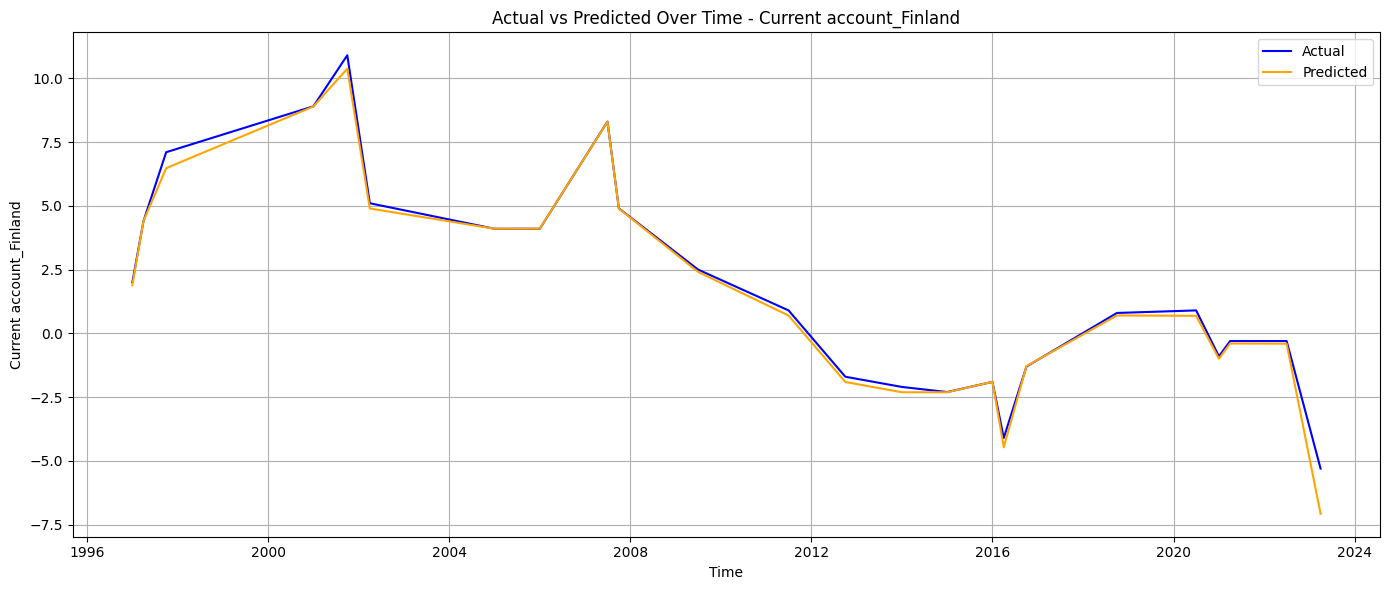

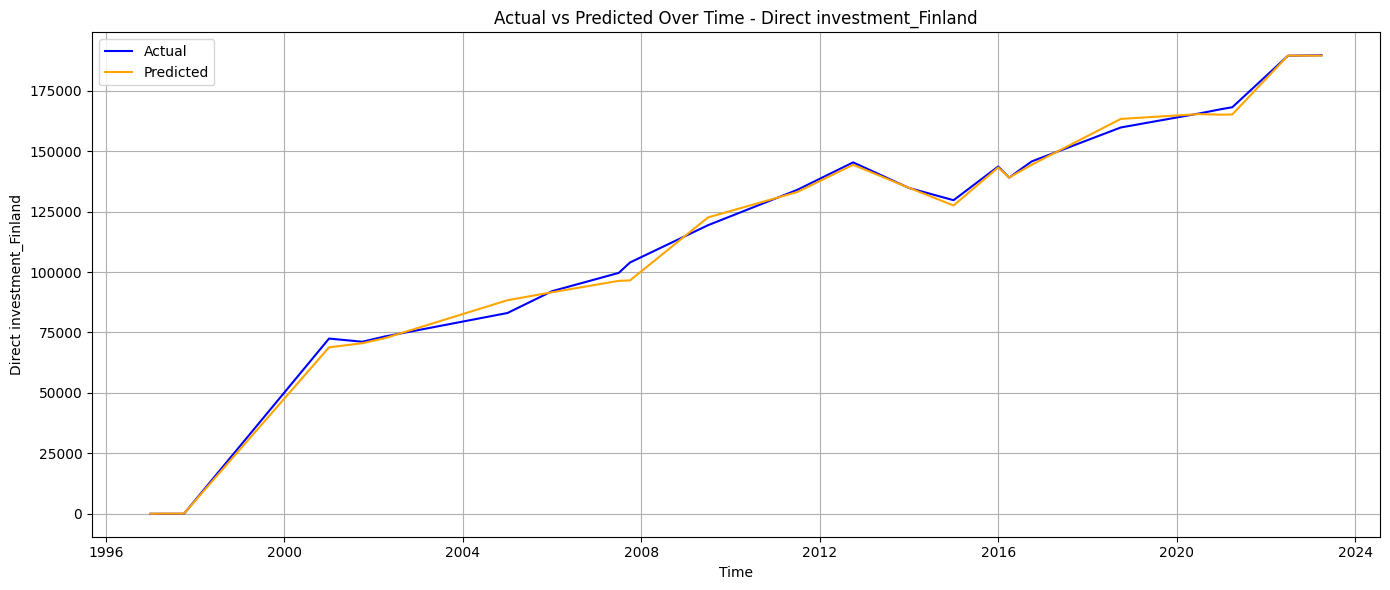

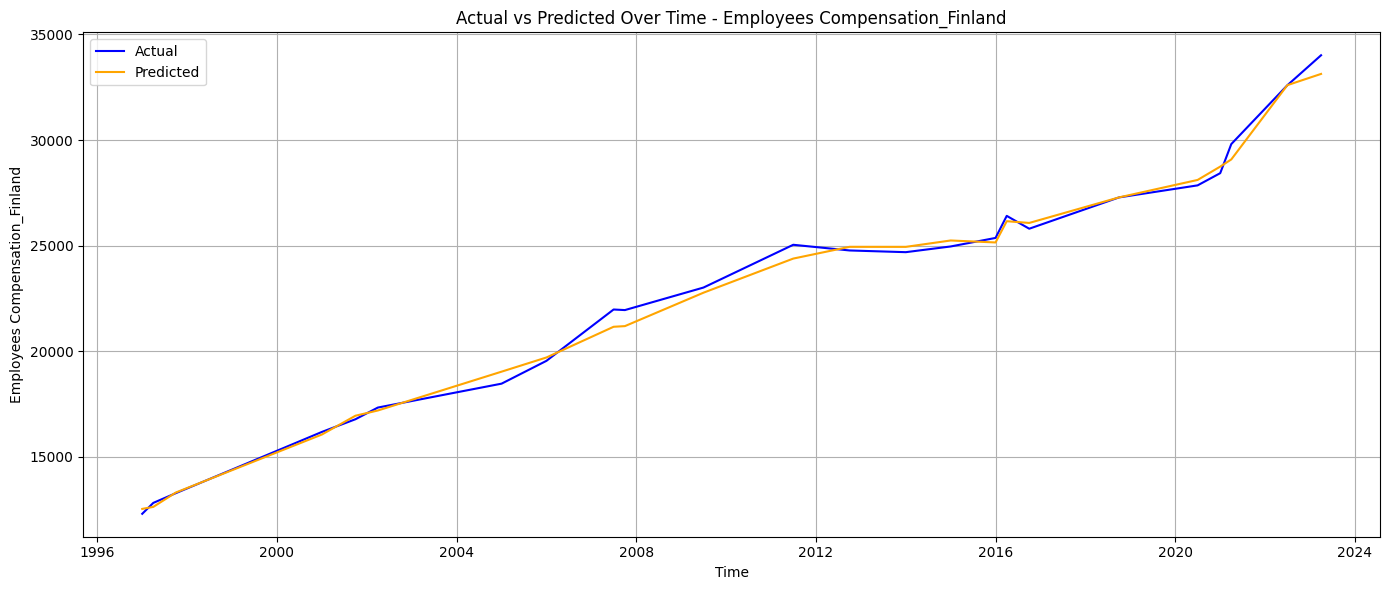

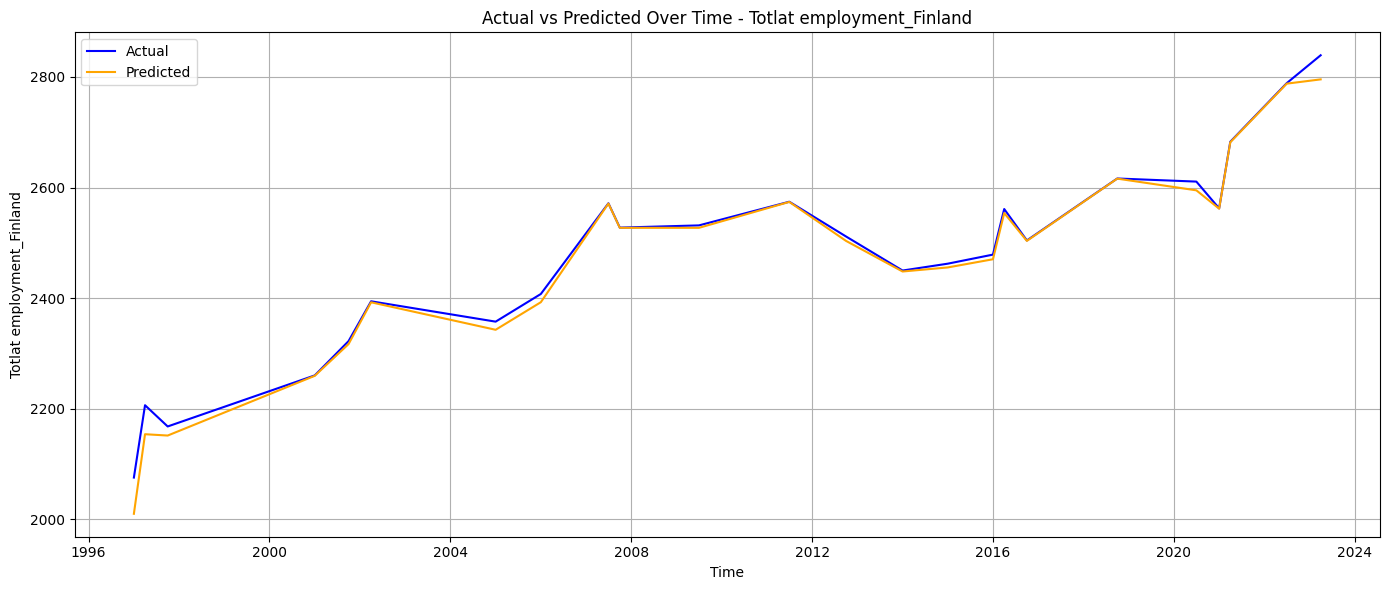

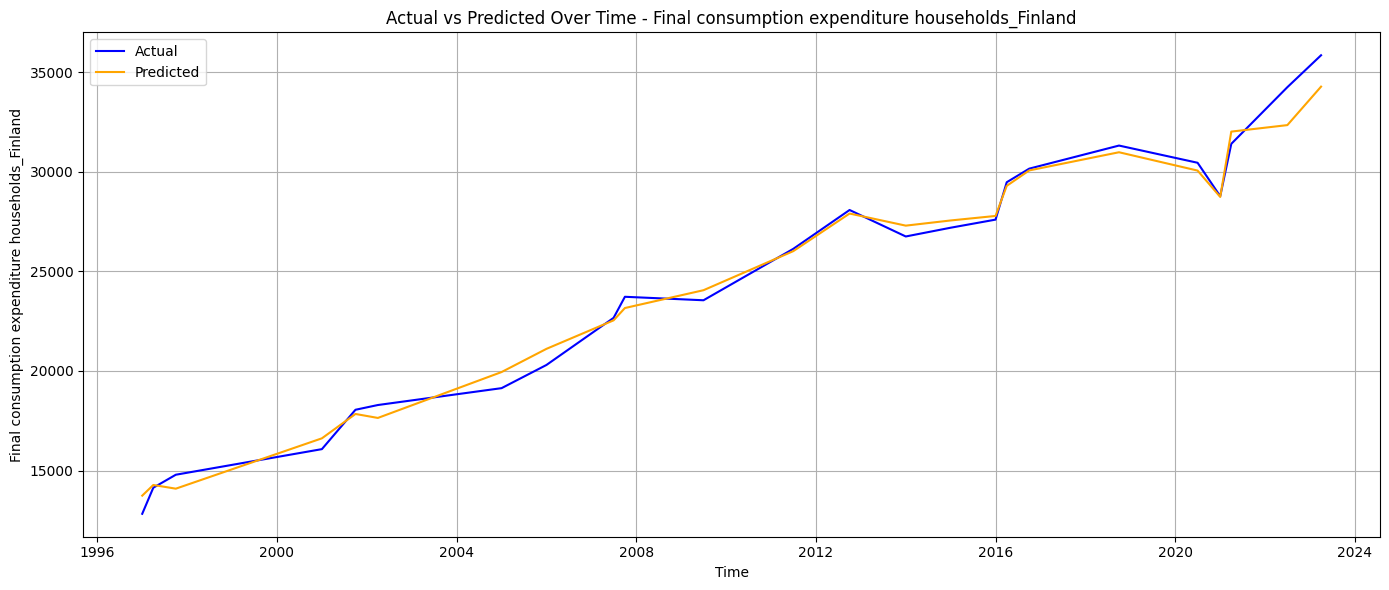

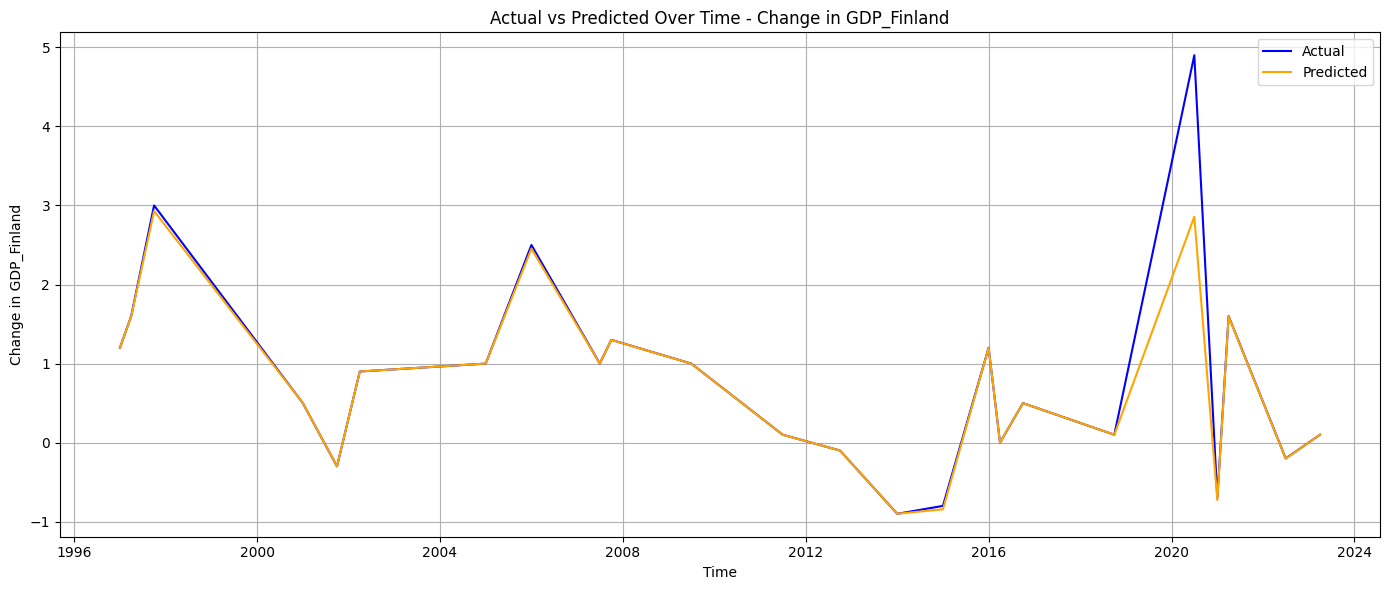

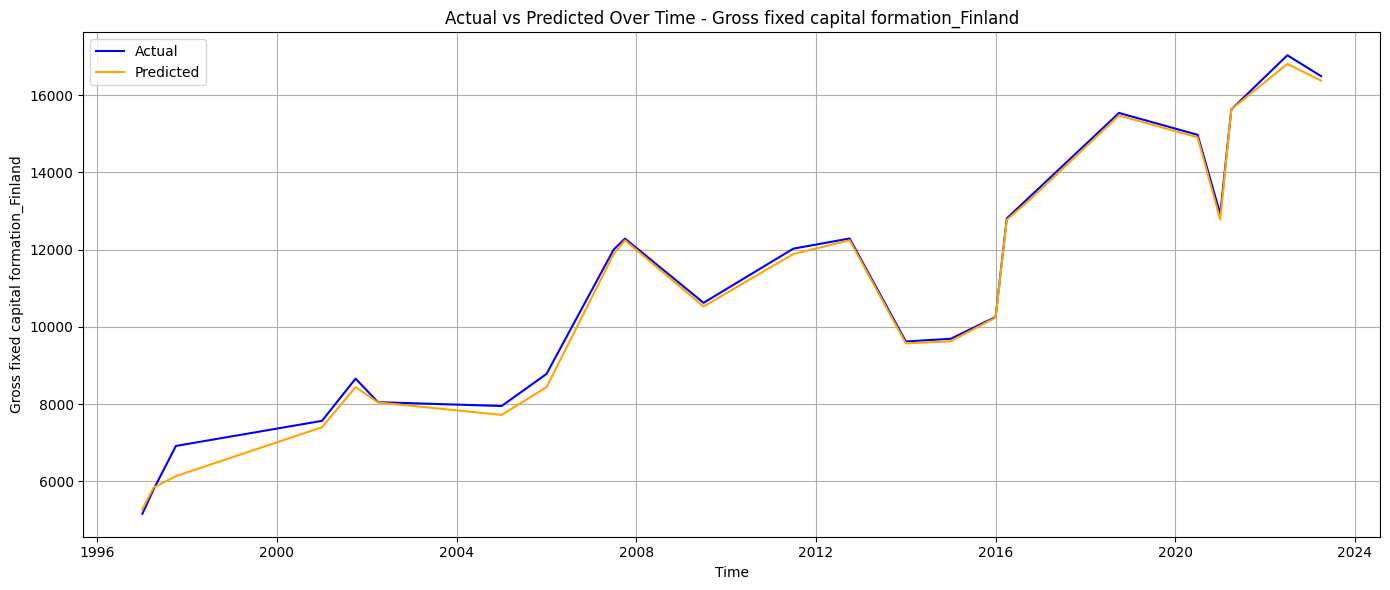

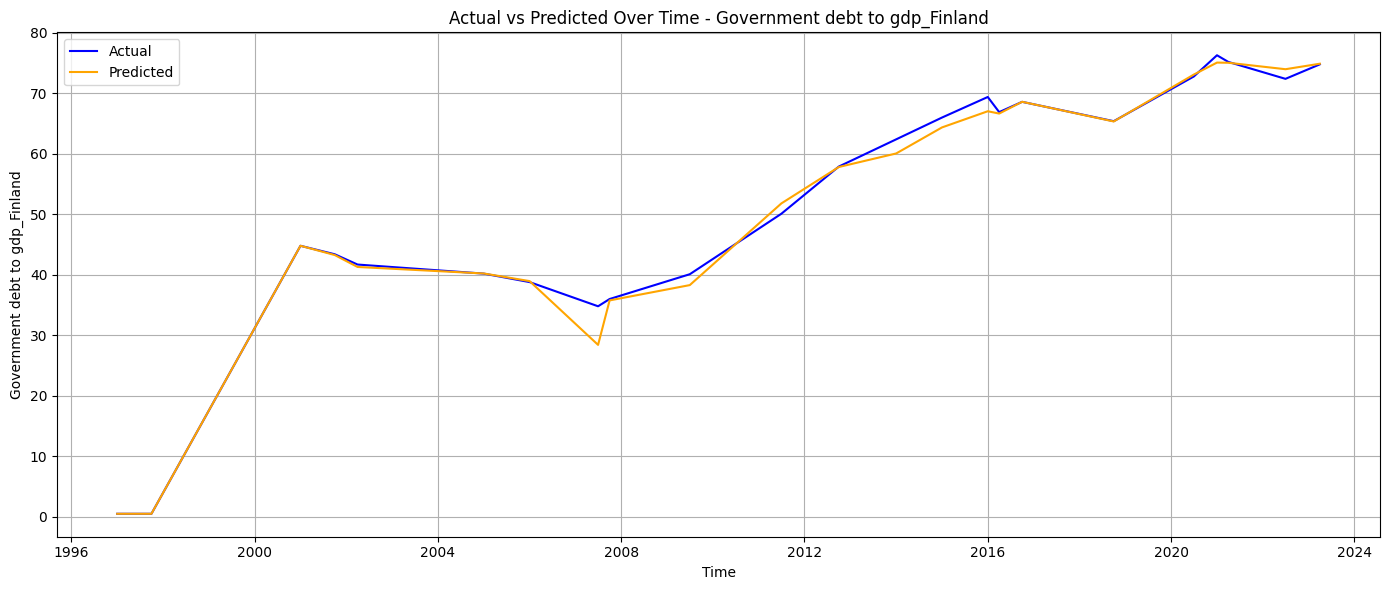

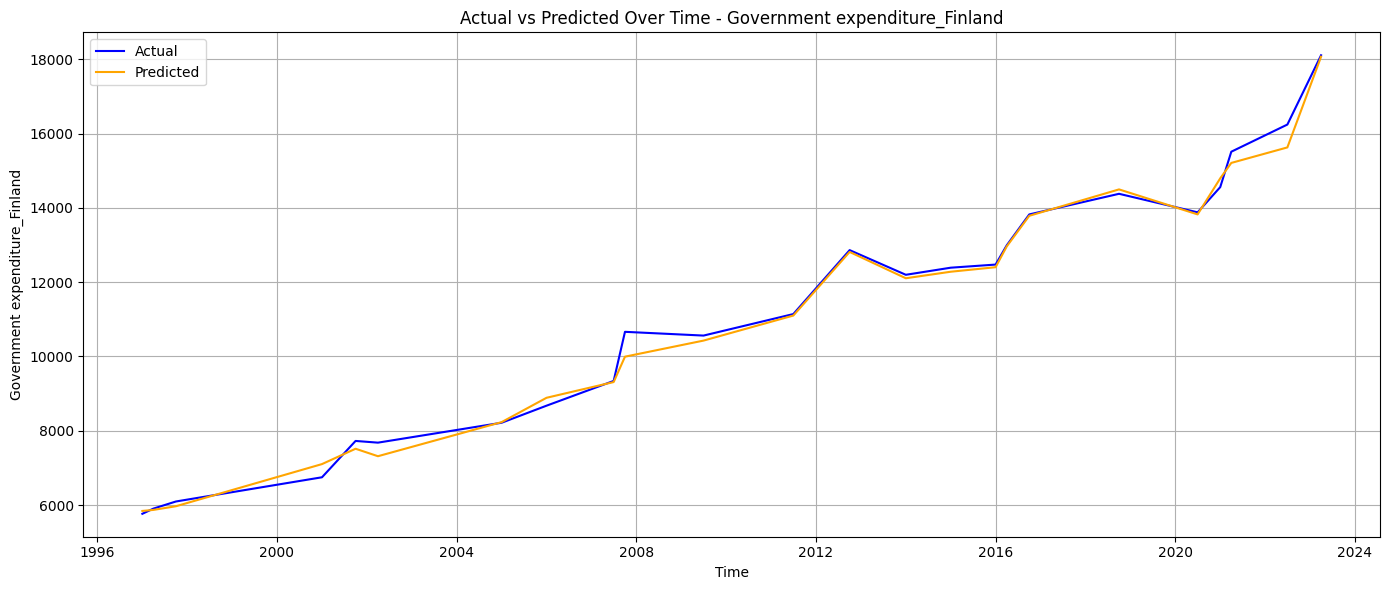

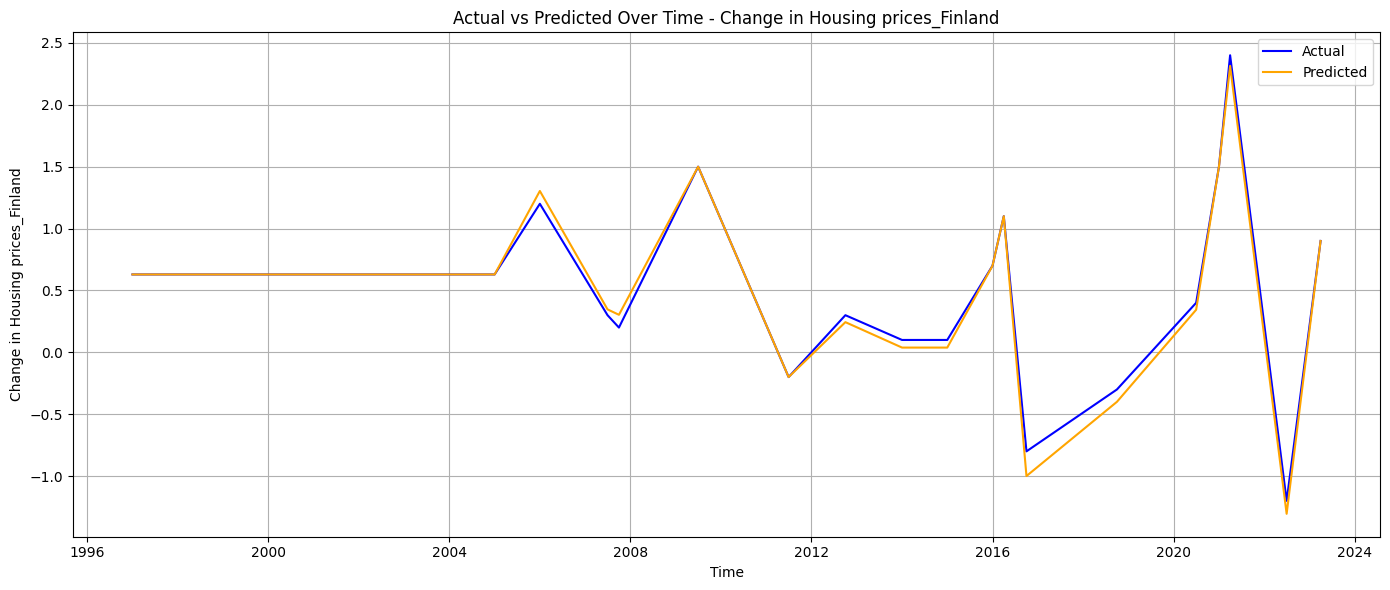

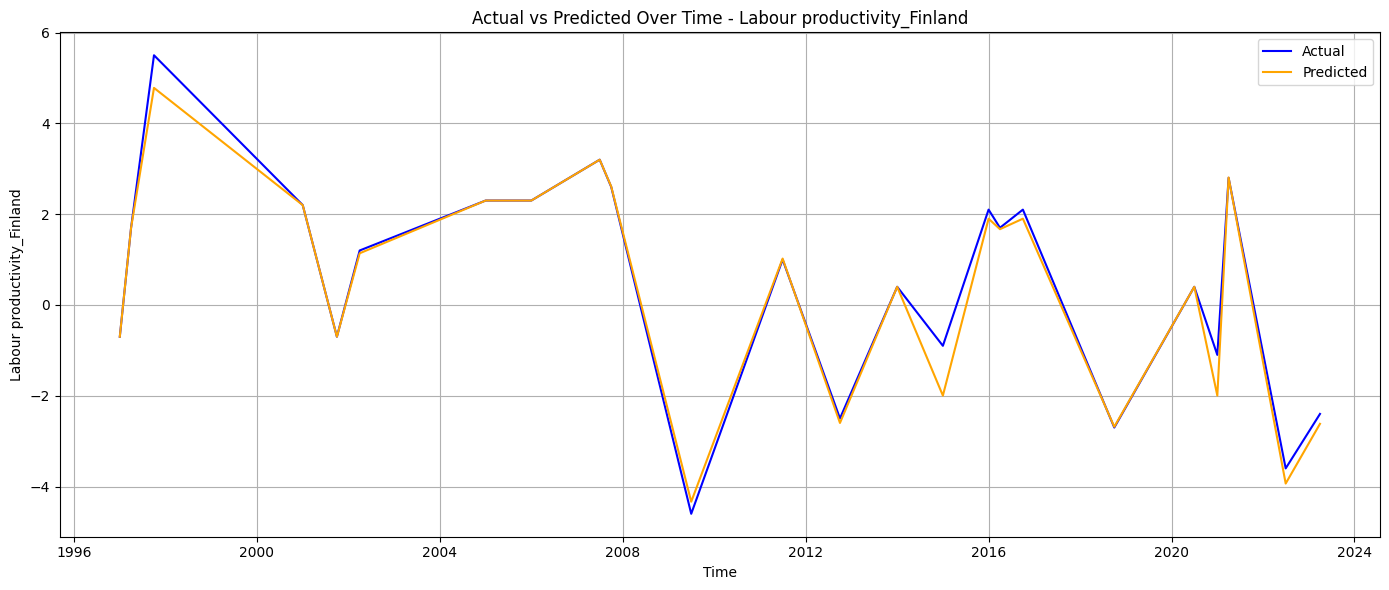

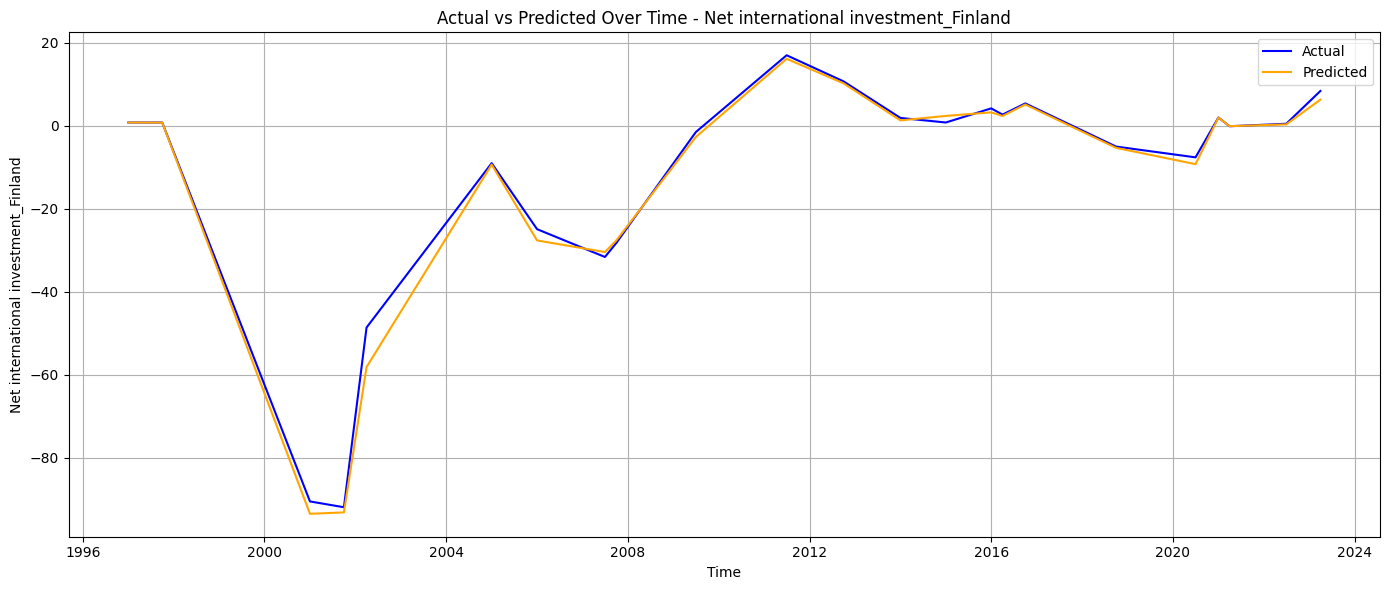

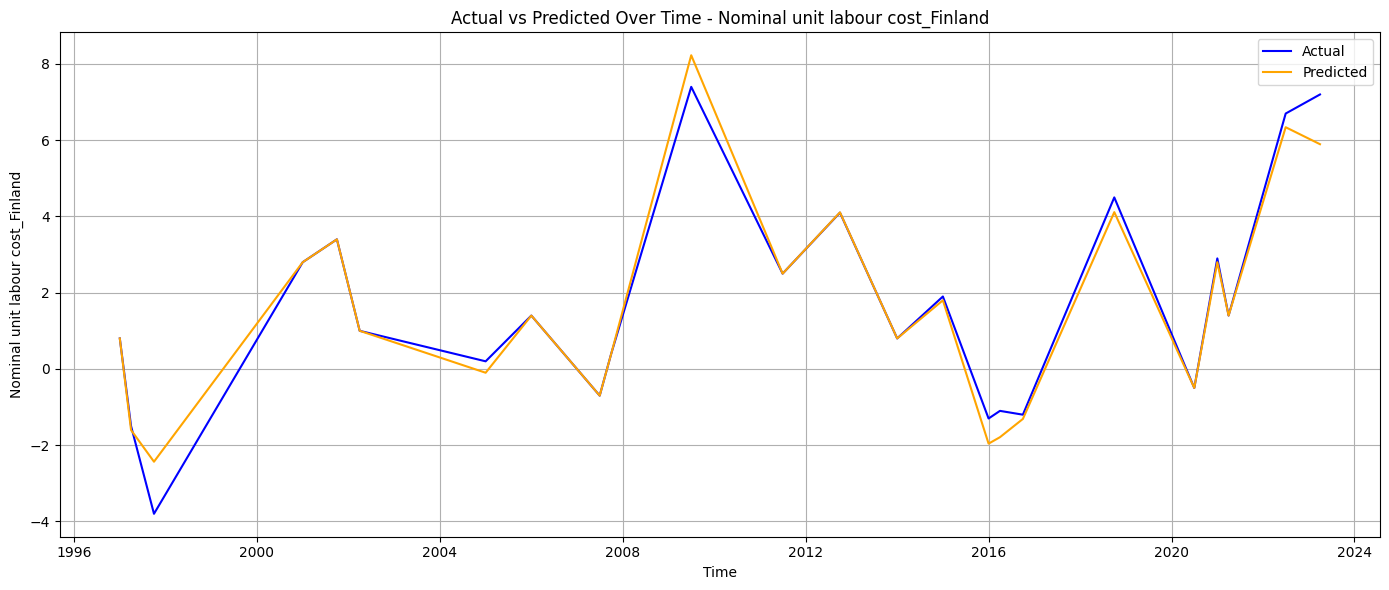

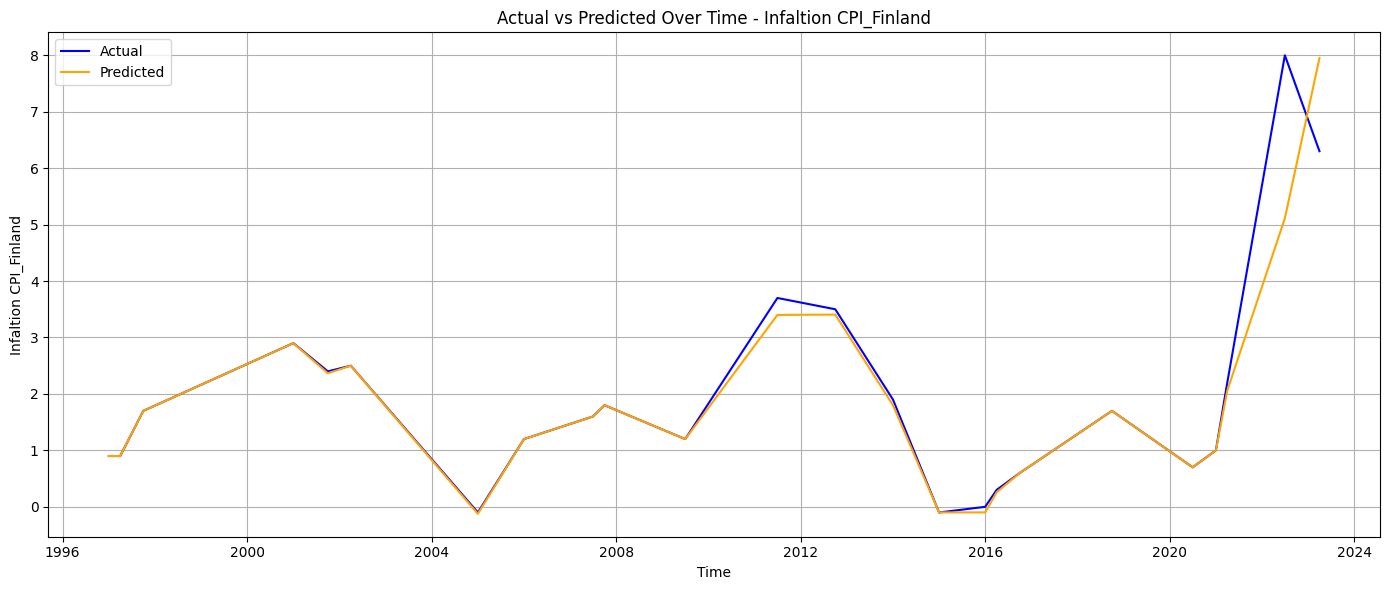

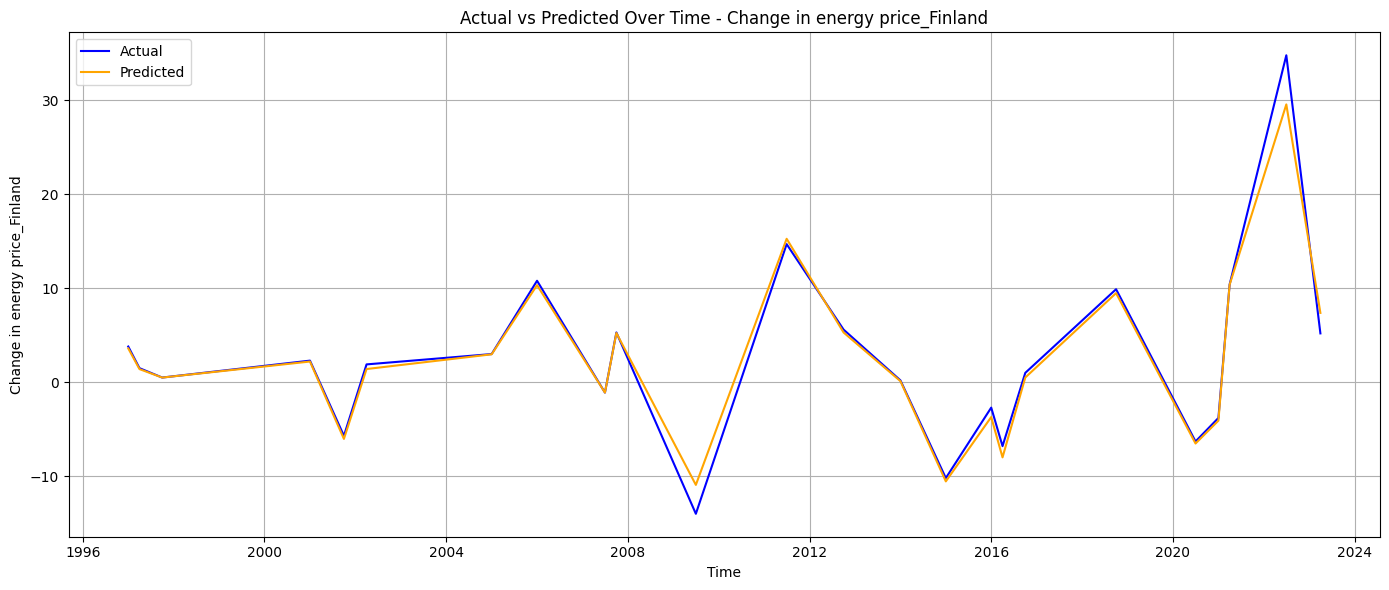

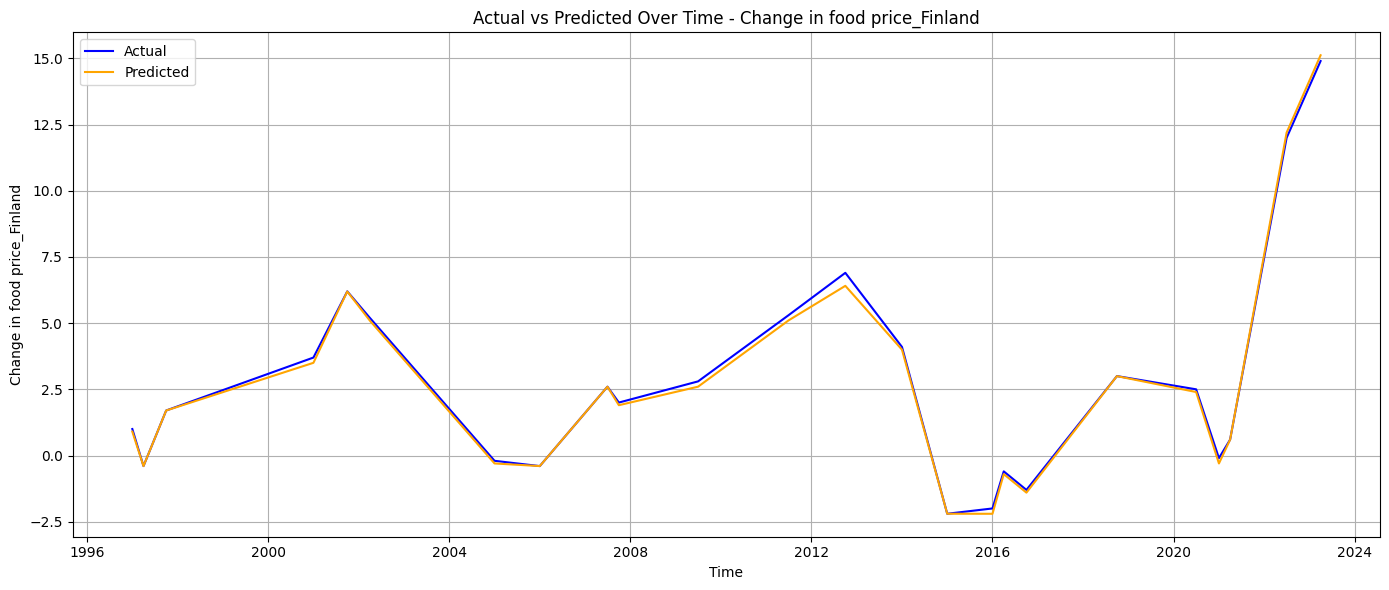

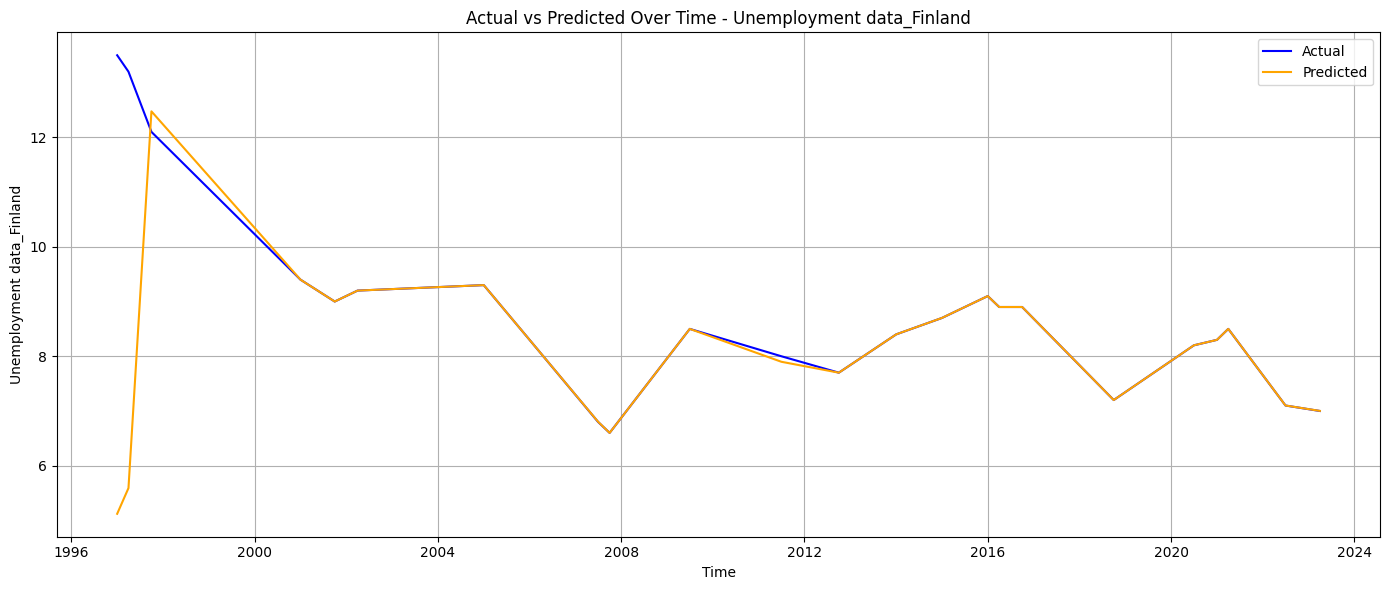

In [161]:
for col in y_test.columns:
    plt.figure(figsize=(14, 6))

    # Create a DataFrame with everything together
    temp_df = pd.DataFrame({
        'Time': time_test,
        'Actual': y_test[col].values,
        'Predicted': y_pred[:, y_test.columns.get_loc(col)]
    })

    # Sort by time to avoid zigzag lines
    temp_df = temp_df.sort_values(by='Time')

    # Plot
    plt.plot(temp_df['Time'], temp_df['Actual'], label='Actual', color='blue')
    plt.plot(temp_df['Time'], temp_df['Predicted'], label='Predicted', color='orange')

    plt.xlabel('Time')
    plt.ylabel(col)
    plt.title(f'Actual vs Predicted Over Time - {col}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()